# Prep Environment

In [1]:
import os

import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Prep Utilities

In [2]:
def calc_autocorr(series, lag=1):
    """Compute lag-1 autocorrelation"""
    return series.autocorr(lag=lag)

def calc_half_life(series):
    """Estimate mean reversion half-life from AR(1) process"""
    series = series.dropna()
    lagged = series.shift(1).dropna()
    delta = series.diff().dropna()

    # Align
    lagged = lagged.loc[delta.index]
    delta = delta.loc[lagged.index]

    # Regress delta ~ lagged
    model = sm.OLS(delta, sm.add_constant(lagged)).fit()
    beta = model.params[1]

    if beta >= 0:
        halflife = -np.log(2) / np.log(1 + beta) if beta < 1 else np.inf
    else:
        halflife = np.nan  # unstable
    return halflife

def calc_hurst(series):
    """Estimate Hurst exponent using R/S method"""
    series = series.dropna()
    N = len(series)
    if N < 100:
        return np.nan
    
    lags = range(2, min(100, N // 2))
    tau = [np.std(series[lag:] - series[:-lag]) for lag in lags]
    if np.any(np.array(tau) <= 0):
        return np.nan
    
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0] * 2.0
    return hurst

def rolling_metrics(data, window_autocorr=120, window_halflife=252, window_hurst=500):
    df = data.copy()

    df["Autocorr"] = df["Return"].rolling(window_autocorr).apply(calc_autocorr, raw=False)
    df["HalfLife"] = df["Return"].rolling(window_halflife).apply(calc_half_life, raw=False)
    df["Hurst"] = df["Return"].rolling(window_hurst).apply(calc_hurst, raw=False)

    return df

# Ingest Data

In [3]:
asset_list_df = pd.read_csv("../config/50 Biggest Market Capitalization - Aug 2025.csv")
asset_list_df

,Code,Listed Stocks,Number of Listed Shares,Market Capitalization IDR,Market Capitalization %
0,BREN,PT Barito Renewables Energy Tbk.,"133,786,220,000","1,207,420,636",8.51
1,BBCA,Bank Central Asia Tbk.,"122,042,299,500","985,491,568",6.95
2,DCII,DCI Indonesia Tbk,"2,383,745,900","811,605,885",5.72
3,DSSA,Dian Swastatika Sentosa Tbk,"7,705,523,200","764,387,901",5.39
4,TPIA,PT Chandra Asri Pacific Tbk,"86,511,545,092","713,720,247",5.03
5,BBRI,PT Bank Rakyat Indonesia (Persero) Tbk,"150,043,411,587","607,675,817",4.28
6,BYAN,Bayan Resources Tbk,"33,333,335,000","605,000,030",4.27
7,AMMN,PT Amman Mineral Internasional Tbk.,"72,518,217,656","569,268,009",4.01
8,BMRI,Bank Mandiri (Persero) Tbk.,"92,399,999,996","437,052,000",3.08
9,TLKM,Telkom Indonesia (Persero) Tbk.,"99,062,216,600","310,064,738",2.19


In [4]:
today = date.today()
target_date = date(2022, 1, 1)
# target_date = date(2025, 8, 15)
time_difference = today - target_date
number_of_days = time_difference.days
market_code = (asset_list_df['Code'] + ".JK").tolist()
all_data = []

file_path = "../data/yfinance_idx_ticker_data.csv"

if os.path.isfile(file_path):
    print("File Already Exists")
    raw_df = pd.read_csv(file_path)    
else:
    print("File Doesn't Exists, Downloading...")
    all_data = []
    for ticker in tqdm(market_code, desc="Fetching OHLCV"):
        try:
            df = yf.download(
                ticker,
                start=target_date,
                end=today,
                progress=False,
                threads=False,
                auto_adjust=False,
            )
            if df.empty:
                raise ValueError("No data returned")
                
            df = df.reset_index()
            df.columns = df.columns.droplevel(level=1)
            df["Ticker"] = ticker
            all_data.append(df)
        except Exception as e:
            print("Ticker", ticker, "Error:", e)
            pass
    
    raw_df = pd.concat(all_data, axis=0).reset_index(drop=True)
    raw_df.to_csv(file_path, index=False)

raw_df

File Already Exists


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,2023-10-09,973.590942,975.0,975.0,975.0,975.0,22298500,BREN.JK
1,2023-10-10,1213.243896,1215.0,1215.0,1060.0,1060.0,13625200,BREN.JK
2,2023-10-11,1512.810425,1515.0,1515.0,1515.0,1515.0,38431400,BREN.JK
3,2023-10-12,1887.268555,1890.0,1890.0,1820.0,1890.0,219262300,BREN.JK
4,2023-10-13,2356.589111,2360.0,2360.0,2240.0,2360.0,39504100,BREN.JK
...,...,...,...,...,...,...,...,...
40831,2025-09-22,510.000000,510.0,510.0,476.0,476.0,556976700,MBMA.JK
40832,2025-09-23,496.000000,496.0,520.0,490.0,515.0,292713300,MBMA.JK
40833,2025-09-24,480.000000,480.0,500.0,472.0,498.0,350720700,MBMA.JK
40834,2025-09-25,464.000000,464.0,484.0,460.0,482.0,305763000,MBMA.JK


# Data Preprocess

In [5]:
base_df = raw_df.copy()
base_df['Date'] = pd.to_datetime(base_df['Date'])
base_df['Return'] = base_df.groupby('Ticker')['Close'].pct_change(1)
base_df = base_df.dropna()
base_df['Moving Average 20'] = base_df.groupby('Ticker')['Close'].rolling(20).mean().reset_index(level=0, drop=True)
base_df['Moving Average 50'] = base_df.groupby('Ticker')['Close'].rolling(50).mean().reset_index(level=0, drop=True)

base_df['Autocorr Lag 1'] = base_df.groupby('Ticker')['Return'].rolling(50).apply(lambda x: x.autocorr(lag=1), raw=False).reset_index(level=0, drop=True)

base_df = base_df.reset_index(drop=True)
base_df


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker,Return,Moving Average 20,Moving Average 50,Autocorr Lag 1
0,2023-10-10,1213.243896,1215.0,1215.0,1060.0,1060.0,13625200,BREN.JK,0.246154,NaN,NaN,NaN
1,2023-10-11,1512.810425,1515.0,1515.0,1515.0,1515.0,38431400,BREN.JK,0.246914,NaN,NaN,NaN
2,2023-10-12,1887.268555,1890.0,1890.0,1820.0,1890.0,219262300,BREN.JK,0.247525,NaN,NaN,NaN
3,2023-10-13,2356.589111,2360.0,2360.0,2240.0,2360.0,39504100,BREN.JK,0.248677,NaN,NaN,NaN
4,2023-10-16,2746.025635,2750.0,2950.0,2400.0,2940.0,227720100,BREN.JK,0.165254,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
40781,2025-09-22,510.000000,510.0,510.0,476.0,476.0,556976700,MBMA.JK,0.085106,444.6,469.74,-0.128139
40782,2025-09-23,496.000000,496.0,520.0,490.0,515.0,292713300,MBMA.JK,-0.027451,448.6,469.36,-0.144091
40783,2025-09-24,480.000000,480.0,500.0,472.0,498.0,350720700,MBMA.JK,-0.032258,452.1,468.96,-0.097867
40784,2025-09-25,464.000000,464.0,484.0,460.0,482.0,305763000,MBMA.JK,-0.033333,453.6,466.94,-0.032695


In [6]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40786 entries, 0 to 40785
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               40786 non-null  datetime64[ns]
 1   Adj Close          40786 non-null  float64       
 2   Close              40786 non-null  float64       
 3   High               40786 non-null  float64       
 4   Low                40786 non-null  float64       
 5   Open               40786 non-null  float64       
 6   Volume             40786 non-null  int64         
 7   Ticker             40786 non-null  object        
 8   Return             40786 non-null  float64       
 9   Moving Average 20  39836 non-null  float64       
 10  Moving Average 50  38336 non-null  float64       
 11  Autocorr Lag 1     37795 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(1)
memory usage: 3.7+ MB


<Axes: xlabel='Date', ylabel='Close'>

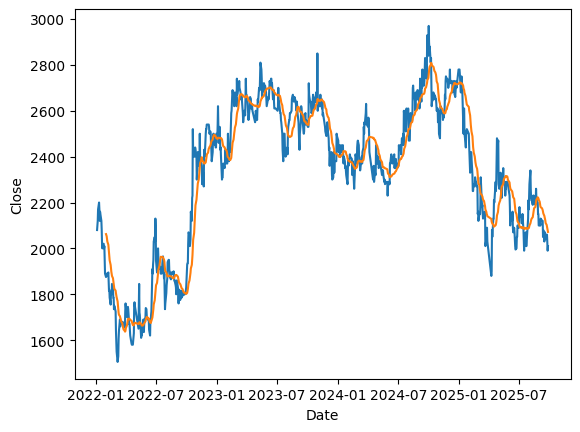

In [7]:
sns.lineplot(data=base_df[base_df['Ticker'] == 'MYOR.JK'], y='Close', x='Date')
sns.lineplot(data=base_df[base_df['Ticker'] == 'MYOR.JK'], y='Moving Average 20', x='Date')

<Axes: xlabel='Autocorr Lag 1', ylabel='Count'>

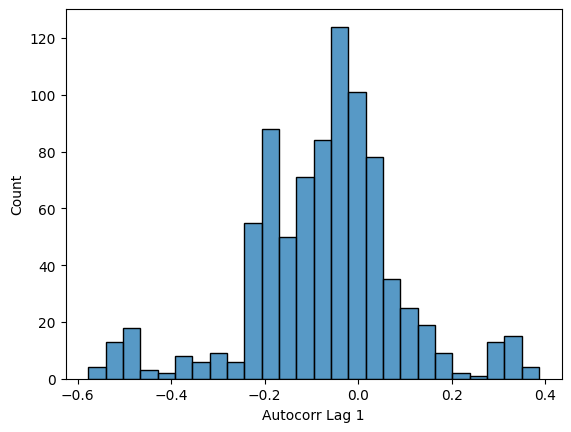

In [8]:
sns.histplot(base_df.loc[base_df['Ticker'] == 'MYOR.JK', 'Autocorr Lag 1'])

In [9]:
base_df.loc[(base_df['Ticker'] == 'MYOR.JK') & (base_df['Autocorr Lag 1'] < -0.5)]

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker,Return,Moving Average 20,Moving Average 50,Autocorr Lag 1
39783,2023-11-29,2376.617676,2500.0,2540.0,2470.0,2530.0,4339600,MYOR.JK,-0.011858,2585.0,2603.0,-0.502814
39784,2023-11-30,2424.149902,2550.0,2550.0,2470.0,2490.0,5587800,MYOR.JK,0.020000,2580.5,2604.0,-0.506459
39785,2023-12-01,2395.630615,2520.0,2550.0,2500.0,2540.0,3989800,MYOR.JK,-0.011765,2575.5,2604.2,-0.521336
39786,2023-12-04,2357.604736,2480.0,2520.0,2460.0,2520.0,5855300,MYOR.JK,-0.015873,2568.5,2602.2,-0.522779
39787,2023-12-05,2310.072266,2430.0,2480.0,2390.0,2480.0,6430500,MYOR.JK,-0.020161,2558.5,2599.0,-0.505954
39788,2023-12-06,2319.578857,2440.0,2470.0,2400.0,2430.0,7177800,MYOR.JK,0.004115,2549.5,2597.0,-0.503638
39790,2023-12-08,2281.552979,2400.0,2450.0,2340.0,2360.0,6244800,MYOR.JK,0.016949,2523.0,2590.0,-0.509305
39791,2023-12-11,2272.046631,2390.0,2430.0,2360.0,2420.0,4974000,MYOR.JK,-0.004167,2510.0,2587.2,-0.508615
39792,2023-12-12,2300.565918,2420.0,2420.0,2360.0,2410.0,2352900,MYOR.JK,0.012552,2500.5,2585.0,-0.508527
39793,2023-12-13,2262.540039,2380.0,2430.0,2370.0,2420.0,2636000,MYOR.JK,-0.016529,2487.5,2582.0,-0.577416


# Simulate Mean Reversion Strategy

In [10]:
def simulate(df, ticker, output_path=None, is_save_chart=False):
    # -----------------------------
    # Prep
    # -----------------------------
    simul_df = df.copy()[df['Ticker'] == ticker]
    simul_df['Return'] = simul_df.groupby('Ticker')['Close'].pct_change(1)
    simul_df['SMA20'] = simul_df.groupby('Ticker')['Close'].rolling(20).mean().reset_index(level=0, drop=True)
    simul_df = simul_df.dropna()

    # -----------------------------
    # Calculate Signal
    # -----------------------------
    threshold = 0.02  # 2%
    simul_df["LowerBand"] = simul_df["SMA20"] * (1 - threshold)

    simul_df["Signal"] = 0  # start flat
    position = 0      # 0 = flat, 1 = long

    for i in range(1, len(simul_df)):
        if position == 0:
            # Entry rule
            if simul_df["Close"].iloc[i] < simul_df["LowerBand"].iloc[i]:
                position = 1  # go long
        elif position == 1:
            # Exit rule
            if simul_df["Close"].iloc[i] >= simul_df["SMA20"].iloc[i]:
                position = 0  # exit
        simul_df.loc[simul_df.index[i], "Signal"] = position

    # -----------------------------
    # Backtest Result
    # -----------------------------
    simul_df["Strategy Return"] = simul_df["Signal"].shift(1) * simul_df["Return"]
    simul_df["Equity Curve"] = (1 + simul_df["Strategy Return"]).cumprod()
    simul_df["Buy"] = (simul_df["Signal"].shift(1)==0) & (simul_df["Signal"]==1)
    simul_df["Sell"] = (simul_df["Signal"].shift(1)==1) & (simul_df["Signal"]==0)

    trx_df = simul_df[simul_df['Buy'] | simul_df['Sell']]
    trx_df['Equity Curve Lead 1'] = trx_df['Equity Curve'].shift(-1)
    trx_df['Sell Date'] = trx_df['Date'].shift(-1)
    trx_df['Sell Close'] = trx_df['Close'].shift(-1)
    trx_df.loc[trx_df['Buy'], 'Trx Return'] = trx_df.loc[trx_df['Buy'], 'Equity Curve Lead 1'] - trx_df.loc[trx_df['Buy'], 'Equity Curve']
    trx_df = trx_df.dropna()[['Trx Return', 'Sell Date', 'Sell Close']]

    simul_df = simul_df.join(trx_df)
    simul_df['Win Loss'] = 'None'
    simul_df['Win Loss'] = simul_df['Win Loss'].case_when([
        (simul_df['Trx Return'] < 0, 'Loss'),
        (simul_df['Trx Return'] > 0, 'Win'),
        (simul_df['Trx Return'] == 0, 'Equal')
    ])

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(12,6))
    ax = sns.lineplot(data=simul_df, y='Close', x='Date', alpha=0.7, label="Close Price")
    sns.lineplot(data=simul_df, y='SMA20', x='Date', alpha=0.7, label="SMA20", ax=ax)
    sns.lineplot(data=simul_df, y='LowerBand', x='Date', alpha=0.7, label="Lower Band", linestyle='--', ax=ax)

    # Buy markers (when position switches from 0→1)
    buy_signals = simul_df[(simul_df["Signal"].shift(1)==0) & (simul_df["Signal"]==1)]
    sns.scatterplot(data=buy_signals, x='Date', y='Close', marker='^', color='g', s=80, label='Buy', ax=ax)

    # Sell markers (when position switches from 1→0)
    sell_signals = simul_df[(simul_df["Signal"].shift(1)==1) & (simul_df["Signal"]==0)]
    sns.scatterplot(data=sell_signals, x='Date', y='Close', marker='v', color='r', s=80, label='Sell', ax=ax)

    plt.title(f"2% SMA20 Mean Reversion Strategy on {ticker}")

    # Set new tick positions by skipping some labels
    tick_positions = ax.get_xticks()
    new_ticks = tick_positions[::45] # Keep every 60th tick
    ax.set_xticks(new_ticks)

    # Rotate the labels
    ax.tick_params(axis='x', rotation=30)
    plt.legend()
    if is_save_chart and output_path != None:
        chart_save_path = os.path.join(output_path, f'mean_reversion_2pct_{ticker}_chart.jpg')
        plt.savefig(chart_save_path)
    else:
        plt.show()

    plt.close()

    # -----------------------------
    # Print Performance
    # -----------------------------

    if output_path != None:
        full_table_save_path = os.path.join(output_path, f'mean_reversion_2pct_{ticker}_full_table.csv')
        simul_df.to_csv(full_table_save_path)
    else:
        total_return = simul_df["Equity Curve"].iloc[-1] - 1
        print(f"Total Return: {total_return:.2%}")
        print(f"Win Rate: {round(sum(simul_df['Win Loss'] == 'Win') / sum(simul_df['Win Loss'] != 'None')*100, 2)}%")
        print(f"Max win: {round(simul_df['Trx Return'].max() * 100, 2)}%")
        print(f"Max Loss: {round(simul_df['Trx Return'].min() * 100, 2)}%")

    return simul_df

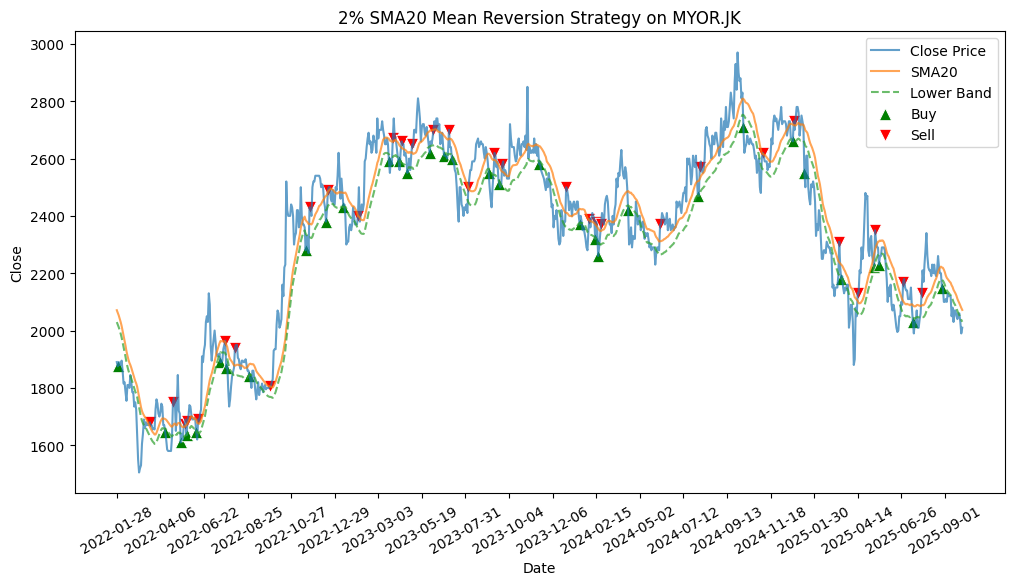

Total Return: 38.53%
Win Rate: 68.75%
Max win: 8.03%
Max Loss: -14.58%


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker,Return,SMA20,LowerBand,Signal,Strategy Return,Equity Curve,Buy,Sell,Trx Return,Sell Date,Sell Close,Win Loss
39387,2022-01-28,1754.441772,1890.0,1950.0,1890.0,1940.0,6452500,MYOR.JK,-0.025773,2071.00,2029.580,0,NaN,NaN,False,False,NaN,NaN,NaN,None
39388,2022-01-31,1740.517700,1875.0,1920.0,1875.0,1890.0,3439900,MYOR.JK,-0.007937,2062.25,2021.005,1,-0.000000,1.000000,True,False,-0.104,2022-03-22,1680.0,Loss
39389,2022-02-02,1754.441772,1890.0,1900.0,1875.0,1880.0,2338900,MYOR.JK,0.008000,2052.75,2011.695,1,0.008000,1.008000,False,False,NaN,NaN,NaN,None
39390,2022-02-03,1745.159058,1880.0,1900.0,1865.0,1885.0,2712900,MYOR.JK,-0.005291,2041.75,2000.915,1,-0.005291,1.002667,False,False,NaN,NaN,NaN,None
39391,2022-02-04,1745.159058,1880.0,1910.0,1860.0,1885.0,3988100,MYOR.JK,0.000000,2029.75,1989.155,1,0.000000,1.002667,False,False,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40256,2025-09-22,2060.000000,2060.0,2080.0,2020.0,2050.0,4542300,MYOR.JK,0.009804,2102.50,2060.450,1,0.009804,1.419736,False,False,NaN,NaN,NaN,None
40257,2025-09-23,2060.000000,2060.0,2110.0,2030.0,2080.0,8137900,MYOR.JK,0.000000,2095.50,2053.590,1,0.000000,1.419736,False,False,NaN,NaN,NaN,None
40258,2025-09-24,2030.000000,2030.0,2060.0,2020.0,2060.0,7909300,MYOR.JK,-0.014563,2087.00,2045.260,1,-0.014563,1.399060,False,False,NaN,NaN,NaN,None
40259,2025-09-25,1990.000000,1990.0,2050.0,1970.0,2050.0,21998600,MYOR.JK,-0.019704,2079.00,2037.420,1,-0.019704,1.371492,False,False,NaN,NaN,NaN,None


In [11]:
import warnings
warnings.filterwarnings("ignore") 

simul_df = simulate(raw_df, 'MYOR.JK')
simul_df

In [12]:
import warnings
warnings.filterwarnings("ignore") 

for ticker in tqdm(raw_df['Ticker'].unique().tolist()):
    simul_df = simulate(raw_df, ticker, '../output/2pct_sma20_mean_reversion', True)
    simul_df

100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


In [ ]:
result = []
for ticker in sorted(raw_df['Ticker'].unique().tolist()):
    ticker_df = pd.read_csv('../output/2pct_sma20_mean_reversion/' + f'mean_reversion_2pct_{ticker}_full_table.csv')
    ticker_result = {'Ticker': ticker}
    ticker_result['Total Trx'] = sum(ticker_df['Buy'])
    ticker_result['Total Return'] = ticker_df["Equity Curve"].iloc[-1] - 1
    ticker_result['Win Rate'] = sum(ticker_df['Win Loss'] == 'Win') / sum(ticker_df['Win Loss'].isin(['Win', 'Loss', 'Equal']))
    ticker_result['Max Win'] = ticker_df['Trx Return'].max()
    ticker_result['Max Loss'] = ticker_df['Trx Return'].min()
    # print(ticker)
    # total_return = ticker_df["Equity Curve"].iloc[-1] - 1
    # print(f"Total Return: {total_return:.2%}")
    # print(f"Win Rate: {round(sum(ticker_df['Win Loss'] == 'Win') / sum(ticker_df['Win Loss'] != 'None')*100, 2)}%")
    # print(f"Max win: {round(ticker_df['Trx Return'].max() * 100, 2)}%")
    # print(f"Max Loss: {round(ticker_df['Trx Return'].min() * 100, 2)}%")
    # print('-'*10)
    # print()
    result.append(ticker_result)

pd.DataFrame(result)

,Ticker,Total Trx,Total Return,Win Rate,Max Win,Max Loss
0,AADI.JK,5,-0.087849,0.600000,0.086538,-0.195773
1,ADRO.JK,32,-0.311552,0.656250,0.110422,-0.434519
2,AMMN.JK,13,0.093982,0.583333,0.225867,-0.298540
3,AMRT.JK,38,0.997912,0.864865,0.152383,-0.272931
4,ANTM.JK,34,0.309738,0.696970,0.160268,-0.299400
5,ASII.JK,29,0.393273,0.724138,0.123527,-0.108769
6,BBCA.JK,25,0.373309,0.750000,0.061341,-0.086893
7,BBNI.JK,26,0.164629,0.640000,0.111621,-0.095890
8,BBRI.JK,25,0.081849,0.680000,0.086815,-0.313738
9,BELI.JK,8,-0.009801,0.500000,0.025943,-0.038645


In [128]:
raw_df['Ticker'].unique().tolist().sort()